# Градиентный бустинг (Gradient Boosting)

## Введение

Gradient Boosting — это мощный ансамблевый алгоритм, который последовательно строит деревья, каждое из которых исправляет ошибки предыдущих. В отличие от Random Forest (bagging), который строит деревья параллельно и независимо, Gradient Boosting использует **boosting** — последовательное обучение.

### Применение в биологии:
- Предсказание активности соединений (drug discovery)
- Классификация белковых последовательностей
- Предсказание клинических исходов
- Анализ геномных данных
- Предсказание токсичности веществ

### Ключевые различия подходов:

| Аспект | Random Forest (Bagging) | Gradient Boosting |
|--------|------------------------|-------------------|
| **Стратегия** | Параллельные независимые деревья | Последовательные зависимые деревья |
| **Цель** | Снизить variance | Снизить bias |
| **Усреднение** | Простое усреднение/голосование | Взвешенная сумма |
| **Деревья** | Глубокие (low bias) | Мелкие (high bias) |
| **Overfitting** | Устойчив | Склонен (нужна регуляризация) |

### Основная идея Gradient Boosting:

1. Начинаем с простой модели (константа или мелкое дерево)
2. Вычисляем ошибки (остатки) текущей модели
3. Обучаем новое дерево предсказывать эти ошибки
4. Добавляем новое дерево к ансамблю с коэффициентом learning_rate
5. Повторяем шаги 2-4

$$F_m(x) = F_{m-1}(x) + \eta \cdot h_m(x)$$

где $\eta$ — learning rate, $h_m(x)$ — новое дерево

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.datasets import make_moons, make_classification
import pandas as pd

np.random.seed(42)

## 1. Визуализация процесса бустинга

Покажем, как постепенно улучшаются предсказания при добавлении новых деревьев.

In [2]:
# Генерируем данные
def true_function(x):
    return np.sin(x) * x + 0.5 * x

n_samples = 100
X_train = np.sort(np.random.uniform(0, 10, n_samples))
y_train = true_function(X_train) + np.random.normal(0, 0.5, n_samples)

X_test = np.linspace(0, 10, 200)
y_test_true = true_function(X_test)

X_train_2d = X_train.reshape(-1, 1)
X_test_2d = X_test.reshape(-1, 1)

print(f"Размер выборки: {n_samples}")

Размер выборки: 100


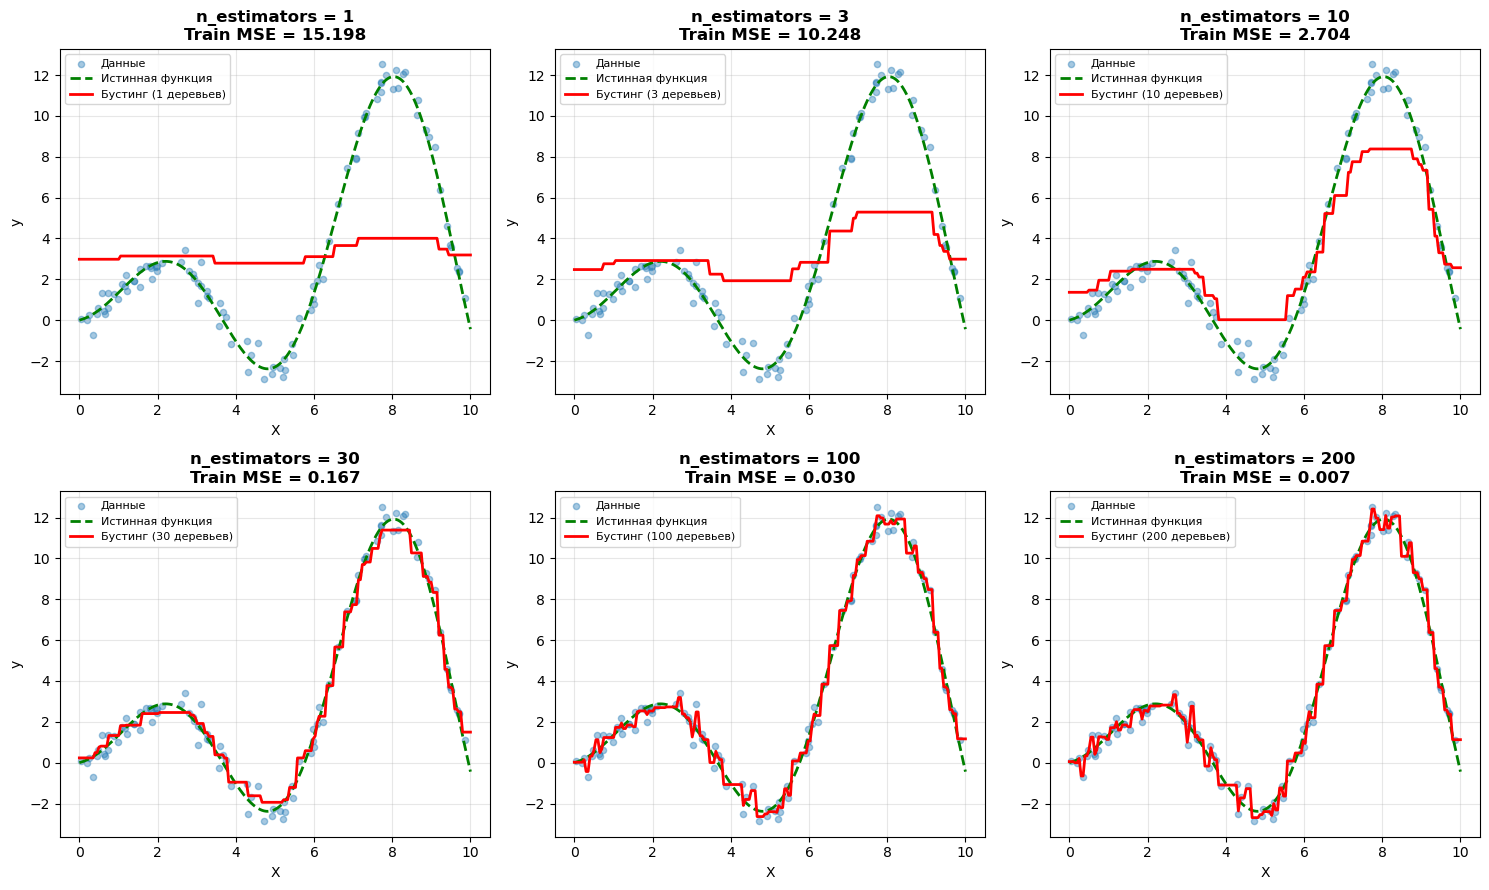


✓ С каждым новым деревом модель лучше аппроксимирует истинную функцию!
  Но слишком много деревьев может привести к overfitting


In [3]:
# Визуализация эволюции бустинга
fig, axes = plt.subplots(2, 3, figsize=(15, 9))
axes = axes.ravel()

n_estimators_stages = [1, 3, 10, 30, 100, 200]

for idx, n_est in enumerate(n_estimators_stages):
    # Обучаем Gradient Boosting
    gb = GradientBoostingRegressor(n_estimators=n_est, max_depth=3, 
                                   learning_rate=0.1, random_state=42)
    gb.fit(X_train_2d, y_train)
    
    y_pred = gb.predict(X_test_2d)
    train_mse = mean_squared_error(y_train, gb.predict(X_train_2d))
    
    # График
    axes[idx].scatter(X_train, y_train, alpha=0.4, s=20, label='Данные')
    axes[idx].plot(X_test, y_test_true, 'g--', lw=2, label='Истинная функция')
    axes[idx].plot(X_test, y_pred, 'r-', lw=2, label=f'Бустинг ({n_est} деревьев)')
    axes[idx].set_xlabel('X')
    axes[idx].set_ylabel('y')
    axes[idx].set_title(f'n_estimators = {n_est}\nTrain MSE = {train_mse:.3f}', fontweight='bold')
    axes[idx].legend(fontsize=8)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ С каждым новым деревом модель лучше аппроксимирует истинную функцию!")
print("  Но слишком много деревьев может привести к overfitting")

## 2. Bias-Variance Tradeoff для Gradient Boosting

### Теория:

Gradient Boosting работает иначе, чем Random Forest:

- **Random Forest**: Начинаем с low bias (глубокие деревья) → снижаем variance через усреднение
- **Gradient Boosting**: Начинаем с high bias (мелкие деревья) → снижаем bias последовательным добавлением деревьев

### Ключевые гиперпараметры:

1. **n_estimators** (количество деревьев):
   - Больше → меньше bias
   - Но МОЖЕТ привести к overfitting!
   
2. **learning_rate** (скорость обучения):
   - Меньше → нужно больше деревьев, но лучше обобщение
   - Типичные значения: 0.01 - 0.3
   
3. **max_depth** (глубина деревьев):
   - Обычно мелкие деревья (3-8)
   - Глубже → больше риск overfitting

### Важный трейдофф:

$$\text{learning\_rate} \times \text{n\_estimators} \approx \text{const}$$

Маленький learning_rate требует больше деревьев, но дает лучшую обобщающую способность.


### Эксперимент: Влияние количества деревьев и learning rate

In [ ]:
# Функция для вычисления bias и variance
def compute_bias_variance_gb(n_estimators, learning_rate, max_depth=3, n_iterations=30):
    """Вычисляет bias и variance для Gradient Boosting"""
    predictions = np.zeros((n_iterations, len(X_test)))
    
    for i in range(n_iterations):
        # Генерируем новую выборку
        X_sample = np.sort(np.random.uniform(0, 10, n_samples))
        y_sample = true_function(X_sample) + np.random.normal(0, 0.5, n_samples)
        
        # Обучаем Gradient Boosting
        gb = GradientBoostingRegressor(n_estimators=n_estimators, 
                                      learning_rate=learning_rate,
                                      max_depth=max_depth, 
                                      random_state=i)
        gb.fit(X_sample.reshape(-1, 1), y_sample)
        
        predictions[i] = gb.predict(X_test_2d)
    
    mean_prediction = np.mean(predictions, axis=0)
    bias_squared = np.mean((mean_prediction - y_test_true)**2)
    variance = np.mean(np.var(predictions, axis=0))
    
    return bias_squared, variance

# Эксперимент 1: влияние n_estimators (при фиксированном learning_rate)
n_trees_range = [1, 5, 10, 20, 50, 100, 200, 300]
biases_trees_gb = []
variances_trees_gb = []

print("Вычисление bias и variance для разного количества деревьев...")
for n_trees in n_trees_range:
    bias_sq, var = compute_bias_variance_gb(n_trees, learning_rate=0.1)
    biases_trees_gb.append(bias_sq)
    variances_trees_gb.append(var)
    print(f"n_estimators={n_trees:3d}: Bias² = {bias_sq:.3f}, Variance = {var:.3f}")

print("\nГотово!")

In [ ]:
# График зависимости от количества деревьев
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(n_trees_range, biases_trees_gb, 'b-o', lw=2, markersize=7, label='Bias²')
ax.plot(n_trees_range, variances_trees_gb, 'r-s', lw=2, markersize=7, label='Variance')
total_error_gb = np.array(biases_trees_gb) + np.array(variances_trees_gb)
ax.plot(n_trees_range, total_error_gb, 'g-^', lw=2.5, markersize=7, label='Total Error')

optimal_n_trees = n_trees_range[np.argmin(total_error_gb)]
ax.axvline(optimal_n_trees, color='purple', linestyle='--', lw=2, alpha=0.7,
          label=f'Оптимум ≈ {optimal_n_trees} деревьев')

ax.set_xlabel('Количество деревьев (n_estimators)', fontsize=12)
ax.set_ylabel('Ошибка', fontsize=12)
ax.set_title('Gradient Boosting: Bias-Variance Tradeoff\n(learning_rate=0.1, max_depth=3)', 
             fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xscale('log')

# Аннотации
ax.annotate('Bias уменьшается', xy=(50, biases_trees_gb[4]), xytext=(20, biases_trees_gb[4]+1),
            arrowprops=dict(arrowstyle='->', color='blue', lw=1.5),
            fontsize=10, color='blue', fontweight='bold')

ax.annotate('Variance растет!\n(overfitting)', xy=(200, variances_trees_gb[-2]), xytext=(80, variances_trees_gb[-2]+1.5),
            arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
            fontsize=10, color='red', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✓ В отличие от Random Forest, слишком много деревьев МОЖЕТ привести к overfitting!")
print(f"✓ Оптимальное количество: ~{optimal_n_trees} деревьев при learning_rate=0.1")

### Эксперимент: Влияние learning rate

In [ ]:
# Сравниваем разные learning rates
learning_rates = [0.01, 0.05, 0.1, 0.3]
n_trees_test = range(10, 201, 20)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, lr in enumerate(learning_rates):
    biases_lr = []
    variances_lr = []
    
    print(f"\nОбработка learning_rate = {lr}...")
    for n_trees in n_trees_test:
        bias_sq, var = compute_bias_variance_gb(n_trees, learning_rate=lr, n_iterations=20)
        biases_lr.append(bias_sq)
        variances_lr.append(var)
    
    total_error_lr = np.array(biases_lr) + np.array(variances_lr)
    
    # График
    axes[idx].plot(n_trees_test, biases_lr, 'b-o', lw=2, markersize=5, label='Bias²')
    axes[idx].plot(n_trees_test, variances_lr, 'r-s', lw=2, markersize=5, label='Variance')
    axes[idx].plot(n_trees_test, total_error_lr, 'g-^', lw=2.5, markersize=5, label='Total Error')
    
    optimal_idx = np.argmin(total_error_lr)
    axes[idx].axvline(list(n_trees_test)[optimal_idx], color='purple', 
                     linestyle='--', lw=2, alpha=0.5)
    
    axes[idx].set_xlabel('n_estimators')
    axes[idx].set_ylabel('Ошибка')
    axes[idx].set_title(f'learning_rate = {lr}\nОптимум: {list(n_trees_test)[optimal_idx]} деревьев', 
                       fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Меньший learning_rate требует больше деревьев, но дает лучший результат!")
print("✓ Компромисс: lr=0.05-0.1 с early stopping")

## 3. Сравнение Gradient Boosting и Random Forest

In [ ]:
# Генерируем данные для классификации
X_class, y_class = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_class, y_class, test_size=0.3, random_state=42
)

# Обучаем модели
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_clf.fit(X_train_c, y_train_c)

gb_clf = GradientBoostingClassifier(n_estimators=100, max_depth=3, 
                                   learning_rate=0.1, random_state=42)
gb_clf.fit(X_train_c, y_train_c)

# Оценка
rf_train_acc = accuracy_score(y_train_c, rf_clf.predict(X_train_c))
rf_test_acc = accuracy_score(y_test_c, rf_clf.predict(X_test_c))

gb_train_acc = accuracy_score(y_train_c, gb_clf.predict(X_train_c))
gb_test_acc = accuracy_score(y_test_c, gb_clf.predict(X_test_c))

print("\n" + "="*60)
print("СРАВНЕНИЕ: RANDOM FOREST vs GRADIENT BOOSTING")
print("="*60)
print(f"Random Forest:")
print(f"  Train Accuracy: {rf_train_acc:.2%}")
print(f"  Test Accuracy:  {rf_test_acc:.2%}")
print(f"  Overfitting gap: {(rf_train_acc - rf_test_acc):.2%}")
print(f"\nGradient Boosting:")
print(f"  Train Accuracy: {gb_train_acc:.2%}")
print(f"  Test Accuracy:  {gb_test_acc:.2%}")
print(f"  Overfitting gap: {(gb_train_acc - gb_test_acc):.2%}")
print(f"\n{'✓ Gradient Boosting обычно точнее, но требует тщательной настройки!' if gb_test_acc > rf_test_acc else '✓ Random Forest более устойчив к overfitting!'}")

### Визуализация границ решений

In [ ]:
def plot_decision_boundary(model, X, y, ax, title):
    """Визуализирует границу решения"""
    h = 0.02
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', edgecolors='black', s=40, alpha=0.7)
    ax.set_title(title, fontweight='bold', fontsize=11)
    ax.set_xlabel('Признак 1')
    ax.set_ylabel('Признак 2')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_decision_boundary(rf_clf, X_test_c, y_test_c, axes[0],
                      f'Random Forest\nTest Acc = {rf_test_acc:.2%}')
plot_decision_boundary(gb_clf, X_test_c, y_test_c, axes[1],
                      f'Gradient Boosting\nTest Acc = {gb_test_acc:.2%}')

plt.tight_layout()
plt.show()

## 4. Регуляризация в Gradient Boosting

Для предотвращения overfitting используются различные техники:

1. **Learning rate**: меньше → медленнее обучение → лучше обобщение
2. **Subsample**: использовать только часть данных для каждого дерева (stochastic gradient boosting)
3. **max_depth**: ограничивать глубину деревьев
4. **min_samples_split / min_samples_leaf**: требовать минимум объектов в узлах
5. **Early stopping**: остановка обучения при ухудшении на валидации

In [ ]:
# Демонстрация влияния subsample
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(
    X_train_2d, y_train, test_size=0.2, random_state=42
)

subsamples = [0.5, 0.7, 1.0]
n_estimators_range = range(1, 201, 5)

fig, ax = plt.subplots(figsize=(10, 6))

for subsample in subsamples:
    train_errors = []
    val_errors = []
    
    for n_est in n_estimators_range:
        gb = GradientBoostingRegressor(n_estimators=n_est, max_depth=3, 
                                      learning_rate=0.1, subsample=subsample,
                                      random_state=42)
        gb.fit(X_train_reg, y_train_reg)
        
        train_errors.append(mean_squared_error(y_train_reg, gb.predict(X_train_reg)))
        val_errors.append(mean_squared_error(y_val_reg, gb.predict(X_val_reg)))
    
    ax.plot(n_estimators_range, val_errors, lw=2, label=f'subsample={subsample}')

ax.set_xlabel('Количество деревьев (n_estimators)', fontsize=12)
ax.set_ylabel('Validation MSE', fontsize=12)
ax.set_title('Влияние subsample на переобучение', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ subsample < 1.0 (stochastic gradient boosting) помогает избежать overfitting!")
print("  Рекомендуемые значения: 0.5-0.8")

## 5. Early Stopping

In [ ]:
# Gradient Boosting с early stopping
gb_early = GradientBoostingRegressor(n_estimators=1000, max_depth=3, 
                                    learning_rate=0.05, subsample=0.8,
                                    validation_fraction=0.2, n_iter_no_change=20,
                                    random_state=42)
gb_early.fit(X_train_2d, y_train)

print(f"\nEarly Stopping:")
print(f"  Максимум итераций: 1000")
print(f"  Фактически использовано: {gb_early.n_estimators_} деревьев")
print(f"  Остановка при отсутствии улучшения за 20 итераций")
print(f"\n✓ Early stopping автоматически находит оптимальное количество деревьев!")

## 6. Важность признаков

In [ ]:
# Генерируем данные с множеством признаков
X_features, y_features = make_classification(
    n_samples=1000, n_features=15, n_informative=8, n_redundant=4,
    n_repeated=0, n_classes=2, random_state=42
)

feature_names = [f'Признак {i+1}' for i in range(15)]

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_features, y_features, test_size=0.3, random_state=42
)

# Обучаем обе модели
rf_feat = RandomForestClassifier(n_estimators=100, random_state=42)
rf_feat.fit(X_train_f, y_train_f)

gb_feat = GradientBoostingClassifier(n_estimators=100, max_depth=3, 
                                    learning_rate=0.1, random_state=42)
gb_feat.fit(X_train_f, y_train_f)

# Сравнение важности признаков
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Random Forest
rf_importances = rf_feat.feature_importances_
rf_indices = np.argsort(rf_importances)[::-1]
axes[0].bar(range(15), rf_importances[rf_indices], color='steelblue', alpha=0.8)
axes[0].set_xticks(range(15))
axes[0].set_xticklabels([feature_names[i] for i in rf_indices], rotation=45, ha='right')
axes[0].set_ylabel('Важность')
axes[0].set_title('Feature Importance: Random Forest', fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Gradient Boosting
gb_importances = gb_feat.feature_importances_
gb_indices = np.argsort(gb_importances)[::-1]
axes[1].bar(range(15), gb_importances[gb_indices], color='darkgreen', alpha=0.8)
axes[1].set_xticks(range(15))
axes[1].set_xticklabels([feature_names[i] for i in gb_indices], rotation=45, ha='right')
axes[1].set_ylabel('Важность')
axes[1].set_title('Feature Importance: Gradient Boosting', fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nСравнение моделей:")
print(f"Random Forest     - Test Accuracy: {accuracy_score(y_test_f, rf_feat.predict(X_test_f)):.2%}")
print(f"Gradient Boosting - Test Accuracy: {accuracy_score(y_test_f, gb_feat.predict(X_test_f)):.2%}")

## 7. Современные реализации: XGBoost и LightGBM

Sklearn's GradientBoosting хорош для понимания, но на практике используют более эффективные реализации:

### XGBoost (Extreme Gradient Boosting):
- Оптимизированная реализация
- Регуляризация L1/L2
- Параллельное построение деревьев
- Обработка пропущенных значений

### LightGBM (Light Gradient Boosting Machine):
- Еще быстрее чем XGBoost
- Leaf-wise рост деревьев (вместо level-wise)
- Эффективна на больших данных

### CatBoost:
- Автоматическая обработка категориальных признаков
- Устойчивость к overfitting
- Хорошие результаты "из коробки"

```python
# Пример использования (требуется установка)
# pip install xgboost lightgbm catboost

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
lgb = LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
cat = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=3, verbose=0)
```

## 8. Резюме

### Bias-Variance Tradeoff: Итоговое сравнение

| Алгоритм | Начальное состояние | Стратегия снижения ошибки | Склонность к overfitting |
|----------|-------------------|--------------------------|-------------------------|
| **Одиночное дерево** | High variance | Ограничение глубины | Очень высокая ↑↑↑ |
| **Random Forest** | High variance (глубокие деревья) | Снижение variance через bagging | Низкая ↓ |
| **Gradient Boosting** | High bias (мелкие деревья) | Снижение bias через boosting | Средняя → |

### Random Forest vs Gradient Boosting:

| Аспект | Random Forest | Gradient Boosting |
|--------|--------------|------------------|
| **Принцип** | Bagging (параллельно) | Boosting (последовательно) |
| **Деревья** | Глубокие, независимые | Мелкие, зависимые |
| **Что снижает** | Variance | Bias |
| **Overfitting** | Устойчив ✓✓ | Склонен ✗ |
| **Скорость** | Быстрее (параллельно) | Медленнее |
| **Настройка** | Проще | Требует внимания |
| **Точность** | Хорошая ✓ | Отличная ✓✓ |
| **n_estimators** | Больше → лучше | Больше → может overfitting |

### Ключевые гиперпараметры Gradient Boosting:

1. **n_estimators**: 100-1000 (с early stopping)
2. **learning_rate**: 0.01-0.3 (меньше = лучше, но медленнее)
3. **max_depth**: 3-8 (мелкие деревья!)
4. **subsample**: 0.5-0.8 (stochastic GB)
5. **min_samples_split**: 2-20

### Практические рекомендации:

**Используйте Random Forest когда:**
- ✓ Нужна устойчивость к overfitting
- ✓ Мало времени на настройку
- ✓ Важна параллелизация
- ✓ Нужны out-of-bag оценки

**Используйте Gradient Boosting когда:**
- ✓ Нужна максимальная точность
- ✓ Есть время на подбор гиперпараметров
- ✓ Можете использовать валидационную выборку
- ✓ Готовы применить XGBoost/LightGBM

### Применение в биологии:

- **Drug discovery**: предсказание активности соединений (XGBoost/LightGBM)
- **Геномика**: предсказание функций генов, вариантов
- **Клинические исходы**: предсказание ответа на терапию
- **Структурная биология**: предсказание структуры белков
- **Системная биология**: анализ многомерных данных

## 9. Задания для самостоятельной работы

1. **Подбор гиперпараметров**: Используйте GridSearchCV или RandomizedSearchCV для оптимизации гиперпараметров Gradient Boosting

2. **Сравнение с XGBoost**: Установите XGBoost и сравните его с sklearn's GradientBoosting на том же датасете

3. **Staged predictions**: Используйте метод `staged_predict` для отслеживания эволюции предсказаний по мере добавления деревьев

4. **Partial Dependence**: Постройте partial dependence plots для анализа влияния отдельных признаков

5. **Реальные биологические данные**: Примените все три алгоритма (Decision Tree, Random Forest, Gradient Boosting) к датасету по классификации рака и сравните результаты

6. **Learning rate schedule**: Экспериментируйте с уменьшением learning rate по мере обучения